In [54]:
#Libraries
using Turing
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Distances
using Random
using Plots
using VectorizedRoutines
using Optim;

In [95]:
#Hyperparameters
n = 10
N = 30
σₐ = 0.1
bound = 1

#Priors for NN
α = 0.09 #"Regularization" Term
σₖ = sqrt(1/α) 
σᵧ = 0.001

k_range = 100
k_list = [Int(i) for i=1:100] #November 3
#k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
k_list_lite = [i for i in 1:k_range]
k_true = 20
k = k_true;

#Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    #PyPlot.colorbar()
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

mₖ(k) = k*4 + 1;

In [3]:
#Generative Interpolator Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    #if(typeof(x) == Float64)
        #x = [x]
    #end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, sigmoid),
               Dense(W₂, b₂))
    return nn(x)
end;

#Create a Random Network
@model function generator(Wₕ, bₕ, Wₒ, bₒ, k)
    α = 0.009 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ MvNormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ MvNormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ MvNormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ MvNormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    #scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    #scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))
    return Wₕ, bₕ, Wₒ, bₒ
    
end;

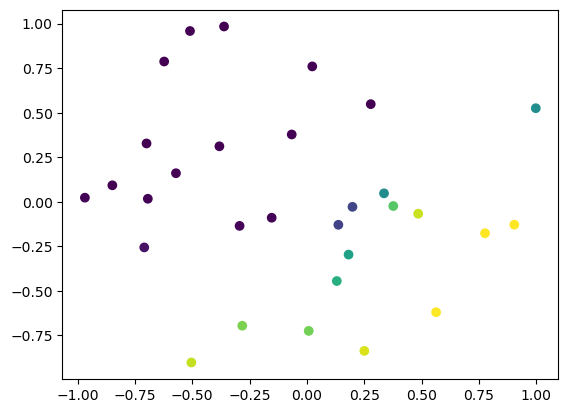

PyObject <matplotlib.collections.PathCollection object at 0x7ff698ab0090>

In [96]:
#Generate Sample Data
k_real = 20
simulation = generator(missing, missing, missing, missing, k_real)
Wₕ, bₕ, Wₒ, bₒ, = simulation()

#Generate Network Parameters and Corresponding Curve
#obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

#(trace,) = generate(generator, (x, k_real), obs)

#Wₕ = trace[:Wₕ]
#Wₒ = trace[:Wₒ]
#bₕ = trace[:bₕ]
#bₒ = trace[:bₒ]

#y_real = Flux.σ.(G(x.*100000,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
y_real = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
#print(y_real)

y_fake = rand(Uniform(0,1),(N))
#y_real = y_fake
plot_data(x_raw,y_real)

In [102]:
#Now we try to learn the generator
@model interpolator(x) = begin
    α = 0.09 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k ~ Categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    #Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Σ₁ = σₖ .* ones(length(μ₁))
    a ~ MvNormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    #Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    Σ₂ = σₖ .* ones(length(μ₂))
    b ~ MvNormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    #Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Σ₃ = σₖ .* ones(length(μ₃))
    c ~ MvNormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    #Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    Σ₄ = σₖ .* ones(length(μ₄))
    d ~ MvNormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,a,b,c,d,k_real)
    scores = Flux.hardσ.(scores,20.0)
    
    #Logistic Regression Likelihood
    y ~ MvNormal(vec(scores), σᵧ .* [i for i=1:length(x[1,:])])
    #return y, Wₕ, bₕ, Wₒ, bₒ, k
    
    return(scores)
    
end;
z = interpolator(x)

DynamicPPL.Model{var"#113#115",(:x,),(),(),Tuple{Transpose{Float64,Array{Float64,2}}},Tuple{}}(:interpolator, var"#113#115"(), (x = [-0.3612738547580241 0.7764448692901511 … -0.509740177989757 0.2782222627507611; 0.9841347188406253 -0.17705192186050578 … 0.9587351199403447 0.5479437443039199],), NamedTuple())

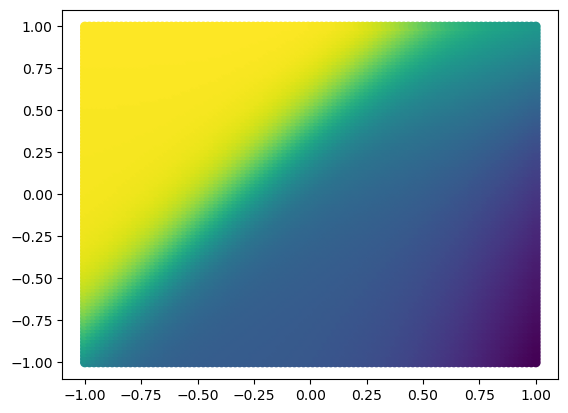

3

PyObject <matplotlib.collections.PathCollection object at 0x7ff6a205b9d0>

In [86]:
#Test out interpolator
chain = sample(interpolator(x, missing, missing), Prior(), 1)
a = collect(Iterators.flatten(get_params(chain).a))
b = collect(Iterators.flatten(get_params(chain).b))
c = collect(Iterators.flatten(get_params(chain).c))
d = collect(Iterators.flatten(get_params(chain).d))
tk = Int(get_params(chain).k[1]);
ty = collect(Iterators.flatten(get_params(chain).y))

print(tk)
plot_data(x_raw,ty);

function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-1.0,1.0)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2,a,b,c,d,tk))[1,:];
plot_data(grid_raw, z)

In [46]:
get_params(chain).lp[1]

-757.0861335878386

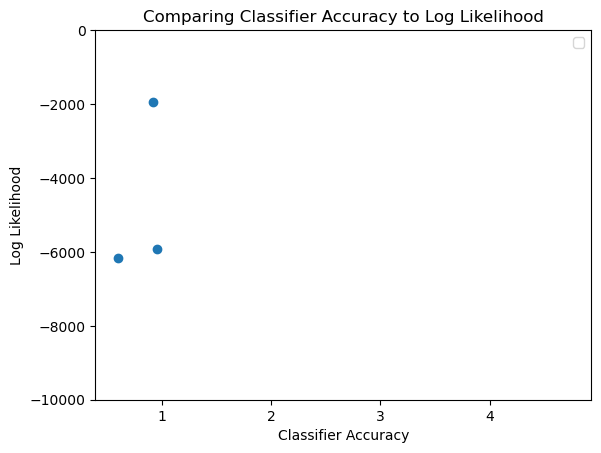

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7ff6a1ed9c50>

In [91]:
#Likelihood sampling
scores = []
distances = []
ks = []
best_ks = []
best_traces = []

best_chain = sample(interpolator(x, y_real, missing), Prior(), 1)
a = collect(Iterators.flatten(get_params(chain).a))
b = collect(Iterators.flatten(get_params(chain).b))
c = collect(Iterators.flatten(get_params(chain).c))
d = collect(Iterators.flatten(get_params(chain).d))
best_k = Int(get_params(chain).k[1]);

best_score = best_chain[:lp][1]
#println(best_score)
best_pred_y = Flux.σ.(G(x,a,b,c,d,best_k))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_dist, best_score, best_k)
    chain = sample(interpolator(x, y_real, missing), Prior(), 1)
    
    a = collect(Iterators.flatten(get_params(chain).a))
    b = collect(Iterators.flatten(get_params(chain).b))
    c = collect(Iterators.flatten(get_params(chain).c))
    d = collect(Iterators.flatten(get_params(chain).d))
    k = Int(get_params(chain).k[1]);
    pred_y = Flux.σ.(G(x,a,b,c,d,k))

    #dist = sqrt(sum((pred_y .- y_real) .^ 2))
    dist = euclidean(pred_y, y_real)
    score = chain[:lp][1]
    #println(score)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_chain = chain
        best_pred_y = pred_y
        best_k = k
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
    #println(best_score)
    return(best_dist, best_score, best_k)
end

for i=1:1000
    best_dist, best_score, best_k = likelihood(best_dist, best_score, best_k)
    push!(best_ks, best_k)
end

PyPlot.scatter(distances, scores)
plt.ylim(-10000,0)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.legend()

In [48]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(chain, current_k)
    
    if current_k == last(k_list)
        new_chain = death(chain)
    elseif current_k == k_list[1]
        new_chain = birth(chain)
    else
        new_chain, new_k = rand(Bernoulli(0.5)) ? birth(chain, current_k) : death(chain, current_k)
    end
    return new_chain, new_k
    
end

function birth(chain, previous_k)

    new_k = k_list[previous_k + 1]
    difference = abs(new_k - previous_k)
    
    a = collect(Iterators.flatten(get_params(chain).a))
    b = collect(Iterators.flatten(get_params(chain).b))
    c = collect(Iterators.flatten(get_params(chain).c))
    d = collect(Iterators.flatten(get_params(chain).d))
    
    new_chain = sample(interpolator(x, y_real, new_k), Prior(), 1)
    
    return new_chain, new_k

end

function death(chain, previous_k)

    new_k = k_list[previous_k - 1]
    difference = abs(previous_k - new_k)
    
    a = collect(Iterators.flatten(get_params(chain).a))
    b = collect(Iterators.flatten(get_params(chain).b))
    c = collect(Iterators.flatten(get_params(chain).c))
    d = collect(Iterators.flatten(get_params(chain).d))
    
    new_chain = sample(interpolator(x, y_real, new_k), Prior(), 1)
    
    return new_chain, new_k
    
end;

In [84]:
output = interpolator(x)
print(output)
map_estimate = optimize(output, MAP())

DynamicPPL.Model{var"#55#56",(:x,),(),(),Tuple{Transpose{Float64,Array{Float64,2}}},Tuple{}}(:interpolator, var"#55#56"(), (x = [-0.09919395038377754 0.6588341176028094 0.009313534635692733 0.6278129613082344 -0.8841419537590904 -0.11925682733958931 0.10208408114003387 -0.3255957947205288 0.13925718787392416 0.4317505321711601 -0.7413462717721453 -0.833716807980585 0.5580548106391396 -0.5863883366442169 0.1333374318858218 0.3481184914704345 0.49356160376895675 0.4989556737334744 0.34932267874468037 0.9678728056120316 0.864686278145129 -0.06809661683109125 -0.6365255732696329 0.9267887876620846 -0.8820480643900614 0.1276617063308252 0.3809065747656897 -0.17513770391803618 -0.7462522979825241 -0.9566243857603478; -0.9588607522342025 -0.6384702036571723 -0.5833748343328886 -0.05391577673673087 -0.3372615665985417 -0.7986424233475082 0.6481354633212391 -0.09237034982071446 0.694940019806574 -0.7567864661723367 -0.11157855219355284 -0.38138676207226396 0.7305035776995052 0.34410090128496496

DimensionMismatch: DimensionMismatch("new dimensions (1, 20) must be consistent with array size 58")

In [49]:
#Turn off info messages
using Logging
Logging.disable_logging(Logging.LogLevel(1000));

In [67]:
chains_list = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(chain, iters, k)
    for i=1:1
        #new_chain = sample(interpolator(x, y_real, k), NUTS(0.80), iters)
        new_chain = sample(interpolator(x, y_real, k), HMCDA(9, 0.65, 0.3), iters)
        #new_chain = sample(interpolator(x, y_real, k), HMC(0.001, 1),1)
        accepted = (new_chain[:is_accept] == 1.0) ? true : false
        if accepted 
            chain = new_chain
        end
        push!(chains_list, chain)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return chain
end

function across_dimension(chain, iters, k)
    
    new_chain, new_k = birth_or_death(chain, k)
    score_test = new_chain[:lp][1]
    #test = true
    for i=1:1
        #new_chain = sample(interpolator(x, y_real, new_k), NUTS(0.50), iters)
        new_chain = sample(interpolator(x, y_real, new_k), HMCDA(1, 0.50, 0.3), iters, init_theta=new_chain)
        #new_chain = sample(interpolator(x, y_real, new_k), HMC(0.6, 20), 1)
        #test = (new_chain[:is_accept][1] == 1.0) ? false : true
    end
    #test && println("Nothing accepted")
    
    score1 = chain[:lp][1]
    score2 = new_chain[:lp][1]
    logscore = (score2 - score1)
    score = exp(logscore)
    #println(score)
    println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        chain = new_chain
        k = new_k
        #println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
        
    push!(chains_list, chain)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return chain, k
end

function rjmcmc(starting_chain, iters)
    chain = starting_chain
    k = Int(get_params(chain).k[1])
    println("Beginning RJMCMC. Starting k: $k")

    for i=1:iters

        if i%10 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #print(obs[:k])
        end
        
        if rand(Uniform(0,1)) > 0.5
            (chain, k) = across_dimension(chain, 10, k)
        else
            (chain) = within_dimension(chain, 10, k)
        end
        println("Epoch $i k-value: $k")
        push!(ks, k)
    end
    
    println("Finished")
end
 
runs = 20
#starting_chain = best_chain
starting_chain = sample(interpolator(x, y_real, missing), Prior(), 1)
k = Int(get_params(starting_chain).k[1])
rjmcmc(starting_chain,runs);

Beginning RJMCMC. Starting k: 58


TypeError: TypeError: in keyword argument init_theta, expected Union{Nothing, Array{T,1} where T}, got Chains{Float64,AxisArrays.AxisArray{Float64,3,Array{Float64,3},Tuple{AxisArrays.Axis{:iter,StepRange{Int64,Int64}},AxisArrays.Axis{:var,Array{Symbol,1}},AxisArrays.Axis{:chain,UnitRange{Int64}}}},Missing,NamedTuple{(:parameters, :internals),Tuple{Array{Symbol,1},Array{Symbol,1}}},NamedTuple{(),Tuple{}}}

In [62]:
#new_chain = sample(interpolator(x, y_real, 12), NUTS(0.65), 1)
new_chain = sample(interpolator(x, y_real, 12), HMCDA(3, 0.65, 0.3), 10)
test = (new_chain[:is_accept][1] == 1.0) ? false : true

false

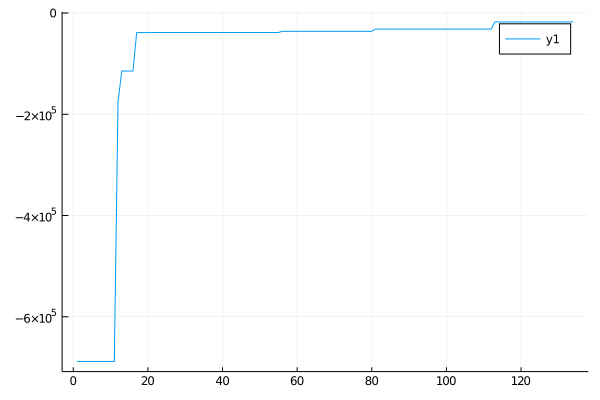

In [95]:
chain_scores = []
for i = 1:length(chains_list)
    current_chain = chains_list[i]
    push!(chain_scores, current_chain[:lp][1])
end
Plots.plot(chain_scores)

MethodError: MethodError: no method matching logpdf(::DynamicPPL.Model{var"#39#41",(:x, :y, :k),(),(),Tuple{Transpose{Float64,Array{Float64,2}},Array{Float64,1},Int64},Tuple{}})
Closest candidates are:
  logpdf(!Matched::DiscreteUniform, !Matched::Int64) at /home/jberez/.julia/packages/Distributions/jFoHB/src/univariate/discrete/discreteuniform.jl:79
  logpdf(!Matched::Hypergeometric, !Matched::Int64) at /home/jberez/.julia/packages/Distributions/jFoHB/src/univariates.jl:560
  logpdf(!Matched::Chernoff, !Matched::Real) at /home/jberez/.julia/packages/Distributions/jFoHB/src/univariate/continuous/chernoff.jl:169
  ...

In [339]:
using AdvancedHMC, Distributions, ForwardDiff

#Initial Parameter Values
a1 = a
b1 = b
c1 = c
d1 = d
k1 = best_k
y1 = ty
total_length = sum(length(a1) + length(b1) + length(c1) + length(d1) + length(y1))

# Define the target distribution
# Target distribution is y output of interpolator network
loglike(a, b, c, d, y, k) = begin
    scores = G(x,a,b,c,d,k)
    scores = Flux.σ.(scores)
    return (
        logpdf(MvNormal(zeros(length(a)), σₖ .* ones(length(a))), a) +
        logpdf(MvNormal(ones(length(b)), σₖ .* ones(length(b))), b) +
        logpdf(MvNormal(zeros(length(c)), σₖ .* ones(length(c))), c) +
        logpdf(MvNormal(ones(length(d)), σₖ .* ones(length(d))), d) +
        logpdf(MvNormal(vec(scores), σᵧ .* [i for i=1:length(x[1,:])]), y) +
        logpdf(Categorical([1/length(k_list) for i=1:length(k_list)]), k)
    )
end
ℓπ(θ) = logpdf(MvNormal(zeros(D), ones(D)), θ)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(total_length)
hamiltonian = Hamiltonian(metric, loglike, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator));

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

MethodError: MethodError: no method matching loglike(::Array{ForwardDiff.Dual{ForwardDiff.Tag{typeof(loglike),Float64},Float64,12},1})
Closest candidates are:
  loglike(::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any) at In[131]:8
  loglike(::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any) at In[339]:14

In [336]:
best_chain = sample(interpolator(x, y_real, 1), Prior(), 1)
a = collect(Iterators.flatten(get_params(best_chain).a))
b = collect(Iterators.flatten(get_params(best_chain).b))
c = collect(Iterators.flatten(get_params(best_chain).c))
d = collect(Iterators.flatten(get_params(best_chain).d))
#best_k = Int(get_params(best_chain).k[1]);
println(best_k)
#ty = collect(Iterators.flatten(get_params(best_chain).y))
best_score = best_chain[:lp][1]
test_score = loglike(a, b, c, d, y_real, 1)
println(best_score)
println(test_score)

40
-36969.5630127097
-36969.5630127097


In [203]:
println(ty)
println(y_real)

[0.000357552603391713, 0.0007408568172859252, 0.0002388415952979349, -0.00258504631161369, -0.00258417855547047, -0.0027733872566401345, 0.009370410552526333, -0.014077650059955581, -0.0018297133431829675, 0.0012784804226859145, 0.006959030666415373, 0.00256345244066935, -0.005626248614925167, -0.019455068848878286, 0.0053990827684331655, -0.008765939147554745, 0.00300271487953044, 0.023209182230735217, 0.005559179939279426, 0.018008494532056142, 0.021543015113273518, 0.00015317383165148373, -0.0047395435754505905, -0.006294256055960317, 0.01776201062528759, -0.024068862829402977, 0.017533938516551283, -0.008743941673811637, -0.003114453600187713, 0.01442006271614716]
[0.97944330674782, 0.9565302736397159, 0.9702060815034471, 0.5722227241764984, 0.2020050574389024, 0.49007384791376907, 0.877714862723634, 0.15181860775171033, 0.25353236859118494, 0.7121862905424259, 0.907483829983735, 0.8928599900249713, 0.9552575442686344, 0.4974040136989644, 0.25829345226083666, 0.9199640035468509, 0.

In [126]:
ℓπ(θ) = logpdf(MvNormal(zeros(length(θ)), ones(length(θ))), θ)
D = 100; initial_θ = rand(D)
initial1 = initial_θ[1:50]
initial2 = initial_θ[51:100]
println(ℓπ(initial_θ))
println(ℓπ(initial1) + ℓπ(initial2))

-108.04984876304255
-108.04984876304255
